In [1]:
import torch, sys, os
print(sys.prefix)

/home/labsisfo/miniconda3/envs/vio-cw


# 1. Project Setup

## 1.1. Package Import

In [2]:
import os, csv, json, random, shutil
from dataclasses import dataclass
from typing import Optional

import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

import timm
from torchmetrics.classification import BinaryF1Score, BinaryAUROC
from sklearn.metrics import confusion_matrix

from torchvision import transforms
import random as pyrand

import io, random
import torchvision.transforms as T

import math, statistics
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

import glob

from sklearn.metrics import roc_curve, auc as sk_auc, precision_recall_curve, f1_score, confusion_matrix
import numpy as np

from collections import Counter

import uuid, socket, getpass, time, math
from datetime import datetime
from typing import Optional, Dict, Any, Tuple

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold

/home/labsisfo/miniconda3/envs/vio-cw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True

Device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


In [4]:
try:
    from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
except Exception as e:
    raise RuntimeError("Install: pip install scikit-learn") from e

## 1.2. Configurations

In [5]:
@dataclass
class TrainConfig:
    train_csv: str = "data/splits/train.csv"
    val_csv:   str = "data/splits/val.csv"
    test_csv:  str = "data/splits/test.csv"
    img_size:  int = 320
    robust_aug: bool = True

    batch_size: int = 32
    num_workers: int = 4
    use_class_weight: bool = True
    use_weighted_sampler: bool = False

    epochs: int = 400
    lr: float = 3e-4
    weight_decay: float = 1e-4
    early_stop_patience: int = 15
    seed: int = 42
    amp: bool = True

    model_name: str = "efficientnetv2_l"
    num_classes: int = 2

    use_distill: bool = False
    teacher_ckpt: str = "models/server/best_server.pt"
    distill_alpha: float = 0.5
    distill_T: float = 6.0

    out_dir: str = "experiments/runs/student_cv_no_distill"
    save_best_name: str = "best_model.pt"

cfg = TrainConfig()

## 1.3. Reproducibility

In [6]:
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(cfg.seed)

# 2. Dataset

## 2.1. Data Initialization

In [7]:
class CSVDataset(Dataset):
    def __init__(self, csv_path: str, transform=None):
        self.samples = []
        with open(csv_path, "r", newline="") as f:
            reader = csv.reader(f)
            header = next(reader)
            if header and header[0].lower() != "path":  # no header case
                f.seek(0); reader = csv.reader(f)
            for row in reader:
                if len(row) >= 2:
                    p, y = row[0], int(row[1])
                    self.samples.append((p, y))
        self.transform = transform

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

In [8]:
def load_csv(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV tidak ditemukan: {path}")
    rows = []
    with open(path, "r", newline="") as f:
        rd = csv.reader(f)
        header = next(rd, None)
        # Jika kolom pertama bukan "path", berarti tidak ada header -> ulang dari awal
        if header and str(header[0]).lower() != "path":
            f.seek(0)
            rd = csv.reader(f)
        for r in rd:
            if not r: 
                continue
            p = r[0]
            y = int(r[1]) if len(r) > 1 and r[1] != "" else 0
            rows.append((p, y))
    return rows


In [9]:
train_csv = "data/splits/train.csv"
val_csv   = "data/splits/val.csv"
test_csv  = "data/splits/test.csv"

train = load_csv(train_csv)
val   = load_csv(val_csv)
test  = load_csv(test_csv)

splits = {"train": train, "val": val, "test": test}

## 2.3. Data Preprocessing

In [10]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [11]:
def safe_open_rgb(path):
    img = Image.open(path)
    if img.mode in ("RGBA", "LA", "P"):
        img = img.convert("RGBA")
        bg = Image.new("RGB", img.size, (0, 0, 0))
        bg.paste(img, mask=img.split()[-1])
        img = bg
    elif img.mode != "RGB":
        img = img.convert("RGB")
    return img

In [12]:
old_getitem = CSVDataset.__getitem__
def _patched_getitem(self, idx):
    p, y = self.samples[idx]
    try:
        img = safe_open_rgb(p)
    except Exception as e:
        from PIL import Image
        img = Image.new("RGB", (cfg.img_size, cfg.img_size), (0,0,0))
    if self.transform:
        img = self.transform(img)
    import torch
    return img, torch.tensor(y, dtype=torch.long)

CSVDataset.__getitem__ = _patched_getitem

In [13]:
class RandomJpegArtifacts(torch.nn.Module):
    """
    Simulate JPEG compression artifacts in-memory (no disk I/O).
    p: probability to apply
    q_range: (min_quality, max_quality)
    """
    def __init__(self, p=0.3, q_range=(40, 70)):
        super().__init__()
        self.p = p
        self.q_range = q_range

    def forward(self, img):
        if random.random() > self.p:
            return img
        buf = io.BytesIO()
        q = random.randint(*self.q_range)
        img.save(buf, format="JPEG", quality=q, optimize=False)  # artifacts
        buf.seek(0)
        comp = Image.open(buf)
        if comp.mode != "RGB":
            comp = comp.convert("RGB")
        return comp

In [14]:
class RandomLowLight(torch.nn.Module):
    """
    Random low-light via simple gamma-like reduction on value.
    """
    def __init__(self, p=0.3, scale_range=(0.6, 0.9)):
        super().__init__()
        self.p = p
        self.scale_range = scale_range

    def forward(self, img):
        if random.random() > self.p:
            return img
        s = random.uniform(*self.scale_range)
        return img.point(lambda v: int(v * s))

In [15]:
def build_transforms(img_size=320, robust_aug=True):
    train_list = [
        T.Resize((img_size, img_size)),
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.2, contrast=0.2),
    ]
    if robust_aug:
        train_list += [
            RandomLowLight(p=0.3, scale_range=(0.6, 0.9)),
            RandomJpegArtifacts(p=0.3, q_range=(40, 70)),
        ]
    train_list += [T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]

    val_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return T.Compose(train_list), val_tf

train_tf, val_tf = build_transforms(cfg.img_size, cfg.robust_aug)

In [16]:
cfg.num_workers = 2

In [17]:
train_ds = CSVDataset(cfg.train_csv, transform=train_tf)
val_ds   = CSVDataset(cfg.val_csv,   transform=val_tf)
test_ds  = CSVDataset(cfg.test_csv,  transform=val_tf)

In [18]:
train_sampler = None
if cfg.use_weighted_sampler:
    labels = [y for _, y in train_ds.samples]
    import numpy as np
    class_count = np.bincount(labels, minlength=2)
    class_weight = 1.0 / np.maximum(class_count, 1)
    sample_weight = [class_weight[y] for y in labels]
    train_sampler = WeightedRandomSampler(sample_weight, num_samples=len(sample_weight), replacement=True)

## 2.4. Data Loading

In [19]:
train_dl = DataLoader(train_ds, batch_size=cfg.batch_size,
                      shuffle=(train_sampler is None), sampler=train_sampler,
                      num_workers=cfg.num_workers, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                      num_workers=cfg.num_workers, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                      num_workers=cfg.num_workers, pin_memory=True)
print("Rebuilt loaders with num_workers =", cfg.num_workers)

Rebuilt loaders with num_workers = 2


In [20]:
def channel_stats_after_transform(rows, transform, k=256):
    import numpy as np
    ps = [p for p,_ in rows]
    sample = ps if len(ps)<=k else np.random.choice(ps, k, replace=False)
    xs=[]
    for p in sample:
        with Image.open(p) as im:
            im = im.convert("RGB")
            xs.append(transform(im))
    X = torch.stack(xs)  # [N,3,H,W]
    mean = X.mean(dim=(0,2,3)).cpu().numpy()
    std  = X.std(dim=(0,2,3)).cpu().numpy()
    return mean, std

In [21]:
mean_tr, std_tr = channel_stats_after_transform(splits["train"], train_tf, k=256)
mean_va, std_va = channel_stats_after_transform(splits["val"],   val_tf,   k=256)
print("Train tensor mean/std:", mean_tr, std_tr)
print("Val   tensor mean/std:", mean_va, std_va)

/home/labsisfo/miniconda3/envs/vio-cw/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train tensor mean/std: [ 0.1465757  -0.04446741  0.0505291 ] [1.3325001 1.3861123 1.3848997]
Val   tensor mean/std: [0.47585347 0.236899   0.3582972 ] [1.4827062 1.562989  1.5922033]


In [22]:
class RowsDataset(Dataset):
    def __init__(self, rows, transform):
        self.rows = rows
        self.transform = transform
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, i):
        p, y = self.rows[i]
        im = Image.open(p).convert("RGB")
        x = self.transform(im) if self.transform else im
        return x, torch.tensor(y, dtype=torch.long)


In [23]:
def compute_class_weight_from_rows(rows, num_classes=2, min_count_eps=1e-6):
    """
    rows: list of (path, label)
    return: torch.FloatTensor shape [num_classes]
    """
    counts = Counter([lbl for _, lbl in rows])
    # pastikan semua kelas ada
    weights = []
    total = sum(counts.values())
    for c in range(num_classes):
        cnt = counts.get(c, 0)
        # skema umum: weight_c = total / (num_classes * count_c)
        w = total / (max(cnt, min_count_eps) * num_classes)
        weights.append(w)
    w = torch.tensor(weights, dtype=torch.float32)
    return w

# 3. Model

## 3.1. Model Factory

In [24]:
def create_model(name: str, num_classes: int = 2, pretrained: bool = True):
    alias = {
        "efficientnetv2_l": "tf_efficientnetv2_l",
    }
    name = alias.get(name, name)
    return timm.create_model(name, pretrained=pretrained, num_classes=num_classes)

In [25]:
@torch.inference_mode()
def measure_latency_ms_per_image(model, img_size=224, device=None, batch_size=1,
                                 warmup=20, iters=100, amp=True):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)
    x = torch.randn(batch_size, 3, img_size, img_size, device=device)
    if device == "cuda":
        torch.cuda.synchronize()
    for _ in range(warmup):
        with torch.amp.autocast('cuda', enabled=(amp and device=="cuda")):
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    for _ in range(iters):
        with torch.amp.autocast('cuda', enabled=(amp and device=="cuda")):
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()
    total_ms = (t1 - t0) * 1000.0
    ms_per_batch = total_ms / iters
    ms_per_img   = ms_per_batch / batch_size
    ips          = 1000.0 / ms_per_img
    return ms_per_img, ips

## 3.2. Distillation

In [26]:
class DistillLoss(nn.Module):
    """
    total = alpha * CrossEntropy(student_logits, y_true)
          + (1-alpha) * KL(softmax(student/T) || softmax(teacher/T)) * T^2
    """
    def __init__(self, alpha=0.5, T=2.0, ce_weight=None):
        super().__init__()
        self.alpha = alpha
        self.T = T
        # <-- pakai class weight jika diberikan
        self.ce = nn.CrossEntropyLoss(weight=ce_weight)

    def forward(self, s_logits, y_true, t_logits=None):
        ce = self.ce(s_logits, y_true)
        if t_logits is None:
            return ce
        log_p_s = F.log_softmax(s_logits / self.T, dim=1)
        p_t     = F.softmax(t_logits / self.T, dim=1)
        kd = F.kl_div(log_p_s, p_t, reduction="batchmean") * (self.T**2)
        return self.alpha * ce + (1 - self.alpha) * kd


In [27]:
def run_one_epoch(model, dl, optimizer=None, scaler=None, criterion=None, teacher=None, kd: Optional[DistillLoss]=None):
    training = optimizer is not None
    model.train(training)

    loss_sum = 0.0
    f1 = BinaryF1Score().to(device)
    auc = BinaryAUROC().to(device)

    for x, y in dl:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)

        if training:
            optimizer.zero_grad(set_to_none=True)
            with torch.no_grad():
                t_logits = teacher(x) if (teacher is not None) else None
            with torch.amp.autocast('cuda', enabled=(scaler is not None)):
                s_logits = model(x)
                loss = (kd(s_logits, y, t_logits) if kd is not None else criterion(s_logits, y))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                s_logits = model(x)
                loss = (kd(s_logits, y, teacher(x)) if (kd and teacher) else criterion(s_logits, y))

        p = torch.softmax(s_logits, dim=1)[:,1]
        f1.update(p, y.bool()); auc.update(p, y.bool())
        loss_sum += loss.item() * x.size(0)

    n = len(dl.dataset)
    return loss_sum/n, f1.compute().item(), auc.compute().item()

## 3.3. Train Loop & Early Stopping

In [28]:
def compute_class_weight_from_ds(ds: CSVDataset):
    labels = [y for _, y in ds.samples]
    counts = np.bincount(labels, minlength=2)
    total  = counts.sum()
    weights = total / (2.0 * np.maximum(counts, 1))
    return torch.tensor(weights, dtype=torch.float32).to(device), counts

In [29]:
# def train_model_with_loaders(cfg: TrainConfig, train_dl_local, val_dl_local, verbose: int = 1, log_csv: bool = False):
#     os.makedirs(cfg.out_dir, exist_ok=True)
#     set_seed(cfg.seed)

#     model = create_model(cfg.model_name, cfg.num_classes).to(device)

#     try:
#         train_rows_src = getattr(train_dl_local.dataset, 'rows', None)
#     except Exception:
#         train_rows_src = None

#     cw = None
#     if train_rows_src is not None:
#         cw = compute_class_weight_from_rows(train_rows_src, num_classes=cfg.num_classes).to(device)
#         if verbose:
#             from collections import Counter
#             cnt = Counter([lbl for _, lbl in train_rows_src])
#             # print(f"class counts: {dict(cnt)} | class weights: {cw.tolist()}")

#     teacher = None
#     kd_loss = None
#     if cfg.use_distill:
#         assert os.path.exists(cfg.teacher_ckpt), f"Teacher ckpt not found: {cfg.teacher_ckpt}"
#         teacher = create_model("efficientnetv2_l", cfg.num_classes).to(device)
#         teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))
#         teacher.eval()
#         for p in teacher.parameters():
#             p.requires_grad = False
#         kd_loss = DistillLoss(alpha=cfg.distill_alpha, T=cfg.distill_T, ce_weight=cw)

#     criterion = nn.CrossEntropyLoss(weight=cw)

#     optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
#     scaler = torch.amp.GradScaler('cuda', enabled=cfg.amp)

#     best_auc, bad = -1.0, 0
#     best_path = os.path.join(cfg.out_dir, cfg.save_best_name)

#     if log_csv:
#         import csv
#         with open(os.path.join(cfg.out_dir, "train_log.csv"), "w", newline="") as f:
#             csv.writer(f).writerow(["epoch","tr_loss","tr_f1","tr_auc","va_loss","va_f1","va_auc"])

#     for epoch in range(1, cfg.epochs + 1):
#         tr_loss, tr_f1, tr_auc = run_one_epoch(
#             model, train_dl_local, optimizer, scaler, criterion, teacher, kd_loss
#         )
#         va_loss, va_f1, va_auc = run_one_epoch(
#             model, val_dl_local, None, None, criterion, teacher, kd_loss
#         )

#         # if verbose:
#         #     print(f"[{epoch:02d}/{cfg.epochs}] "
#         #           f"train: loss={tr_loss:.4f} f1={tr_f1:.3f} auc={tr_auc:.3f} | "
#         #           f"val: loss={va_loss:.4f} f1={va_f1:.3f} auc={va_auc:.3f}")

#         if log_csv:
#             with open(os.path.join(cfg.out_dir, "train_log.csv"), "a", newline="") as f:
#                 import csv
#                 csv.writer(f).writerow([epoch, tr_loss, tr_f1, tr_auc, va_loss, va_f1, va_auc])

#         # early stopping by val AUC
#         if va_auc > best_auc:
#             best_auc, bad = va_auc, 0
#             torch.save(model.state_dict(), best_path)
#         else:
#             bad += 1
#             if bad >= cfg.early_stop_patience:
#                 if verbose:
#                     print("Early stopping triggered.")
#                 break

#     if verbose:
#         print("Best val AUC:", round(best_auc, 4), "| saved:", best_path)
#     return best_path, best_auc


# EARLY STOP F1
def train_model_with_loaders(cfg: TrainConfig, train_dl_local, val_dl_local, verbose: int = 1, log_csv: bool = False):
    os.makedirs(cfg.out_dir, exist_ok=True)
    set_seed(cfg.seed)

    model = create_model(cfg.model_name, cfg.num_classes).to(device)

    try:
        train_rows_src = getattr(train_dl_local.dataset, 'rows', None)
    except Exception:
        train_rows_src = None

    cw = None
    if train_rows_src is not None:
        cw = compute_class_weight_from_rows(train_rows_src, num_classes=cfg.num_classes).to(device)
        if verbose:
            from collections import Counter
            cnt = Counter([lbl for _, lbl in train_rows_src])
            print(f"class counts: {dict(cnt)} | class weights: {cw.tolist()}")

    teacher = None
    kd_loss = None
    if cfg.use_distill:
        assert os.path.exists(cfg.teacher_ckpt), f"Teacher ckpt not found: {cfg.teacher_ckpt}"
        teacher = create_model("efficientnetv2_l", cfg.num_classes).to(device)
        teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))
        teacher.eval()
        for p in teacher.parameters():
            p.requires_grad = False
        kd_loss = DistillLoss(alpha=cfg.distill_alpha, T=cfg.distill_T, ce_weight=cw)

    criterion = nn.CrossEntropyLoss(weight=cw)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.amp.GradScaler('cuda', enabled=cfg.amp)

    # track best F1 instead of best AUC
    best_f1, bad = -1.0, 0
    best_path = os.path.join(cfg.out_dir, cfg.save_best_name)

    if log_csv:
        import csv
        with open(os.path.join(cfg.out_dir, "train_log.csv"), "w", newline="") as f:
            csv.writer(f).writerow(["epoch","tr_loss","tr_f1","tr_auc","va_loss","va_f1","va_auc"])

    for epoch in range(1, cfg.epochs + 1):
        tr_loss, tr_f1, tr_auc = run_one_epoch(
            model, train_dl_local, optimizer, scaler, criterion, teacher, kd_loss
        )
        va_loss, va_f1, va_auc = run_one_epoch(
            model, val_dl_local, None, None, criterion, teacher, kd_loss
        )

        if verbose:
            print(f"[{epoch:02d}/{cfg.epochs}] "
                  f"train: loss={tr_loss:.4f} f1={tr_f1:.3f} auc={tr_auc:.3f} | "
                  f"val: loss={va_loss:.4f} f1={va_f1:.3f} auc={va_auc:.3f}")

        if log_csv:
            with open(os.path.join(cfg.out_dir, "train_log.csv"), "a", newline="") as f:
                import csv
                csv.writer(f).writerow([epoch, tr_loss, tr_f1, tr_auc, va_loss, va_f1, va_auc])

        # early stopping by val F1 (bukan AUC lagi)
        if va_f1 > best_f1:
            best_f1, bad = va_f1, 0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            # if bad >= cfg.early_stop_patience:
            #     if verbose:
            #         print("Early stopping triggered.")
            #     break

    if verbose:
        print("Best val F1:", round(best_f1, 4), "| saved:", best_path)
    return best_path, best_f1


In [30]:
def select_student_via_cv(student_candidates, k=5, seed=42):
    all_rows = splits["train"] + splits["val"]
    X = [p for p,_ in all_rows]
    y = np.array([lbl for _,lbl in all_rows])
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    results = []
    perfold = {}

    for name, img_sz, bs in student_candidates:
        fold_metrics = []
        perfold[name] = []

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
            train_rows = [all_rows[i] for i in tr_idx]
            val_rows   = [all_rows[i] for i in va_idx]
            train_tf, val_tf = build_transforms(img_sz, cfg.robust_aug)

            ds_tr = RowsDataset(train_rows, train_tf)
            ds_va = RowsDataset(val_rows,   val_tf)
            dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=cfg.num_workers, pin_memory=True)
            dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

            tr_counts = Counter([lbl for _, lbl in train_rows])
            va_counts = Counter([lbl for _, lbl in val_rows])
            
            tr_total = len(train_rows); va_total = len(val_rows)
            tr_pos = tr_counts.get(1, 0); tr_neg = tr_counts.get(0, 0)
            va_pos = va_counts.get(1, 0); va_neg = va_counts.get(0, 0)
            
            def _ratio(pos, total): 
                return (pos / total) if total else 0.0
            
            print(
                f"[{name}] Fold {fold}/{k} | "
                f"TRAIN: n={tr_total} (neg={tr_neg}, pos={tr_pos}, pos_ratio={_ratio(tr_pos,tr_total):.3f}) | "
                f"VAL: n={va_total} (neg={va_neg}, pos={va_pos}, pos_ratio={_ratio(va_pos,va_total):.3f}) | "
                f"batches: train={len(dl_tr)}, val={len(dl_va)}"
            )

            out_dir = f"experiments/runs/cv_{k}/student_{name.replace('.','_')}/fold_{fold}"
            cfg_student = TrainConfig(
                model_name=name, out_dir=out_dir, save_best_name="best_student.pt",
                use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
                distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
                img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
                use_class_weight=True, use_weighted_sampler=False
            )
            best_path, _ = train_model_with_loaders(cfg_student, dl_tr, dl_va, verbose=0, log_csv=True)

            model = create_model(name, 2).to(device)
            model.load_state_dict(torch.load(best_path, map_location=device)); model.eval()
            ce = nn.CrossEntropyLoss()
            va_loss, va_f1, va_auc = run_one_epoch(model, dl_va, optimizer=None, scaler=None, criterion=ce)

            fold_metrics.append((va_auc, va_f1))
            perfold[name].append({"fold": fold, "val_auc": float(va_auc), "val_f1": float(va_f1)})

        mean_auc = float(np.mean([a for a,_ in fold_metrics]))
        mean_f1  = float(np.mean([f for _,f in fold_metrics]))
        print(f"[CV] {name}: mean AUC={mean_auc:.3f} | mean F1={mean_f1:.3f}")
        results.append((name, mean_auc, mean_f1))

    results.sort(key=lambda t: (t[1], t[2]), reverse=True)
    best_name = results[0][0]
    return best_name, results, perfold

## 3.4. Temperature scaling

In [31]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1)*1.0)
    def forward(self, x):
        return self.model(x) / self.temperature.clamp(0.5, 5.0)

## 3.5. Testing Evaluation

In [32]:
def quick_test_eval(ckpt_path: str, model_name: str, dl):
    model = create_model(model_name, 2).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    ce = nn.CrossEntropyLoss()

    loss, f1, auc = run_one_epoch(model, dl, optimizer=None, scaler=None, criterion=ce)
    print(f"[TEST] loss={loss:.4f}  F1={f1:.3f}  AUC={auc:.3f}")

    y_prob, y_true = [], []
    with torch.no_grad():
        for x, y in dl:
            x = x.to(device)
            p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
            y_prob.append(p); y_true.append(y.numpy())
    y_prob = np.concatenate(y_prob); y_true = np.concatenate(y_true)
    y_hat  = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    print("Confusion Matrix (thr=0.5)\n[[TN FP]\n [FN TP]]\n", cm)
    return loss, f1, auc, cm

## 3.6. Training

### 3.6.2. Student Model

In [33]:
import warnings
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")
# warnings.filterwarnings("ignore", message="FutureWarning: You are using `torch.load` with `weights_only=False`")

In [34]:
[m for m in timm.list_models(pretrained=True) if "mobilenetv3" in m or "efficientnet_lite" in m][:20]

['efficientnet_lite0.ra_in1k',
 'mobilenetv3_large_100.miil_in21k',
 'mobilenetv3_large_100.miil_in21k_ft_in1k',
 'mobilenetv3_large_100.ra_in1k',
 'mobilenetv3_rw.rmsp_in1k',
 'mobilenetv3_small_050.lamb_in1k',
 'mobilenetv3_small_075.lamb_in1k',
 'mobilenetv3_small_100.lamb_in1k',
 'tf_efficientnet_lite0.in1k',
 'tf_efficientnet_lite1.in1k',
 'tf_efficientnet_lite2.in1k',
 'tf_efficientnet_lite3.in1k',
 'tf_efficientnet_lite4.in1k',
 'tf_mobilenetv3_large_075.in1k',
 'tf_mobilenetv3_large_100.in1k',
 'tf_mobilenetv3_large_minimal_100.in1k',
 'tf_mobilenetv3_small_075.in1k',
 'tf_mobilenetv3_small_100.in1k',
 'tf_mobilenetv3_small_minimal_100.in1k']

In [35]:
student_candidates = [
    ("tf_efficientnet_lite2.in1k",        260, 48)
]

In [36]:
KD_RUNS_DIR = "experiments/runs/kd_alpha"
os.makedirs(KD_RUNS_DIR, exist_ok=True)

def kd_outdir(a: float) -> str:
    return os.path.join(KD_RUNS_DIR, f"alpha_{a:.1f}".replace(".", "_"))

In [37]:
def plot_run_curves(run_dir, title=None):
    csv_path = os.path.join(run_dir, "train_log.csv")
    if not os.path.exists(csv_path):
        print("missing:", csv_path); return
    df = pd.read_csv(csv_path)
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(df.epoch, df.tr_loss, label="train"); ax[0].plot(df.epoch, df.va_loss, label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(df.epoch, df.tr_f1, label="train"); ax[1].plot(df.epoch, df.va_f1, label="val")
    ax[1].set_title("F1")
    ax[2].plot(df.epoch, df.tr_auc, label="train"); ax[2].plot(df.epoch, df.va_auc, label="val")
    ax[2].set_title("AUC")
    if title: fig.suptitle(title)
    plt.show()

In [38]:
def plot_kd_val_curves(kd_root, metrics=("va_loss","va_f1","va_auc"), title="Knowledge Distillation"):
    paths = sorted(glob.glob(os.path.join(kd_root, "alpha_*", "train_log.csv")))
    if not paths:
        print("Belum ada log KD di", kd_root)
        return

    alphas, csvs = [], []
    for p in paths:
        folder = os.path.basename(os.path.dirname(p))
        a_str = folder.split("alpha_")[-1].replace("_", ".")
        try:
            alphas.append(float(a_str)); csvs.append(p)
        except:
            pass

    order = np.argsort(alphas)
    alphas = [alphas[i] for i in order]
    csvs   = [csvs[i]   for i in order]

    a_min, a_max = min(alphas), max(alphas)
    def color_for(a):
        t = (a - a_min) / (a_max - a_min + 1e-9)
        return plt.cm.Greys(t)

    fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 6), sharex=True, constrained_layout=True)
    if len(metrics) == 1:
        axes = [axes]
    for ax in axes:
        try:
            ax.set_box_aspect(1.0)
        except Exception:
            pass

    for a, csv_path in zip(alphas, csvs):
        df = pd.read_csv(csv_path)
        for ax, m in zip(axes, metrics):
            ax.plot(df["epoch"], df[m], label=f"α={a:.1f}", linewidth=1.8, color=color_for(a))

    name_map = {"va_loss":"Validation Loss", "va_f1":"Validation F1", "va_auc":"Validation AUC"}
    for ax, m in zip(axes, metrics):
        ax.set_xlabel("Epoch")
        ax.set_ylabel(name_map.get(m, m))
        ax.grid(True, alpha=0.3)

    labels_to_handles = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for hh, ll in zip(h, l):
            if ll not in labels_to_handles:
                labels_to_handles[ll] = hh
        leg = ax.get_legend()
        if leg:
            leg.remove()

    fig.suptitle(title, y=1.02)
    fig.legend(list(labels_to_handles.values()), list(labels_to_handles.keys()),
               loc="upper center", ncol=min(6, len(labels_to_handles)),
               frameon=False, bbox_to_anchor=(0.5, 1.10))
    plt.show()

In [39]:
# # best_name, cv_table, cv_perfold = select_student_via_cv(student_candidates, k=5, seed=cfg.seed)
# # print("Best via CV:", best_name)

# # cand = [(n, sz, bs) for (n, sz, bs) in student_candidates]

# # lat_rows = []
# # for name, img_sz, bs in cand:
# #     m = create_model(name, 2, pretrained=True).to(device).eval()
# #     ms1, ips1 = measure_latency_ms_per_image(m, img_size=img_sz, device=device, batch_size=1, warmup=30, iters=120, amp=True)
# #     ms8, ips8 = measure_latency_ms_per_image(m, img_size=img_sz, device=device, batch_size=8, warmup=20, iters=80, amp=True)
# #     lat_rows.append({
# #         "model": name,
# #         "img_size": img_sz,
# #         "latency_ms_1x": float(ms1),
# #         "ips_1x": float(ips1),
# #         "latency_ms_8x": float(ms8),
# #         "ips_8x": float(ips8),
# #     })

# # df_latency = pd.DataFrame(lat_rows)
# # df_latency

# # print("\n== CV Summary (mean over folds) ==")
# # print(f"{'model':30s}  {'mean_auc':>8s}  {'mean_f1':>8s}")
# # for name, mean_auc, mean_f1 in cv_table:
# #     print(f"{name:30s}  {mean_auc:8.4f}  {mean_f1:8.4f}")

# # print("\n== Per-fold scores ==")
# # for name in cv_perfold:
# #     rows = cv_perfold[name]
# #     aucs = ", ".join(f"{r['val_auc']:.4f}" for r in rows)
# #     f1s  = ", ".join(f"{r['val_f1']:.4f}" for r in rows)
# #     print(f"{name:30s} | AUC: [{aucs}] | F1: [{f1s}]")

# # df_summary = pd.DataFrame(cv_table, columns=["model","mean_auc","mean_f1"]).sort_values("mean_auc", ascending=False)
# # display(df_summary)

# # score_kd = df_summary.merge(df_latency, on="model", how="left")

# # AUC_EPS = 0.005
# # auc_max = score_kd["mean_auc"].max()
# # candidates_eps = score_kd[score_kd["mean_auc"] >= auc_max - AUC_EPS]
# # picked_pareto = candidates_eps.sort_values(["latency_ms_1x","mean_f1"], ascending=[True, False]).iloc[0]

# # def minmax(s): return (s - s.min()) / (s.max() - s.min() + 1e-9)
# # norm_auc = minmax(score_kd["mean_auc"])
# # norm_lat = minmax(score_kd["latency_ms_1x"])
# # ALPHA = 0.7
# # score_kd["composite"] = ALPHA*norm_auc + (1-ALPHA)*(1 - norm_lat)
# # picked_comp = score_kd.sort_values(["composite","mean_f1"], ascending=[False, False]).iloc[0]

# # print("\nBest via AUC+Latency:", picked_pareto["model"])
# # best_name = picked_pareto["model"]  # ganti model terbaik hasil CV biasa
# # display(score_kd)

# # plt.figure(figsize=(4,3))
# # plt.scatter(score_kd["latency_ms_1x"], score_kd["mean_auc"], s=80)
# # for i,row in score_kd.iterrows():
# #     plt.text(row["latency_ms_1x"]*1.02, row["mean_auc"], row["model"], fontsize=8)
# # plt.xlabel("Latency per image (ms)")
# # plt.ylabel("Mean AUC (CV)")
# # plt.title("Accuracy–Latency Trade-off")
# # plt.grid(True, alpha=0.3)
# # plt.show()

# # os.makedirs("experiments/summary", exist_ok=True)
# # score_kd.sort_values(["mean_auc","latency_ms_1x"], ascending=[False, True]).to_csv(
# #     "experiments/summary/student_cv_latency.csv", index=False
# # )
# # print("Saved summary with latency ranking ✓")

# # rows = []
# # for name, items in cv_perfold.items():
# #     for it in items:
# #         rows.append({"model": name, "fold": it["fold"], "val_auc": it["val_auc"], "val_f1": it["val_f1"]})
# # df_perfold = pd.DataFrame(rows).sort_values(["model","fold"])
# # display(df_perfold)

# # import glob

# # base_dir = "experiments/runs/cv_5"
# # students = [d for d in os.listdir(base_dir) if d.startswith("student_")]

# # for stu in students:
# #     model_name = stu.replace("student_", "")
# #     fold_paths = sorted(glob.glob(os.path.join(base_dir, stu, "fold_*", "train_log.csv")))
# #     if not fold_paths:
# #         continue

# #     plt.figure(figsize=(4, 3))
# #     for csv_path in fold_paths:
# #         fold_id = int(csv_path.split("fold_")[-1].split("/")[0])
# #         df = pd.read_csv(csv_path)
# #         plt.plot(df["epoch"], df["va_auc"], label=f"Fold {fold_id} AUC", linewidth=1.6)
# #     plt.title(f"{model_name} – Validation AUC per Fold")
# #     plt.xlabel("Epoch")
# #     plt.ylabel("Validation AUC")
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)
# #     plt.tight_layout()
# #     plt.show()

# #     plt.figure(figsize=(4, 3))
# #     for csv_path in fold_paths:
# #         fold_id = int(csv_path.split("fold_")[-1].split("/")[0])
# #         df = pd.read_csv(csv_path)
# #         plt.plot(df["epoch"], df["va_f1"], label=f"Fold {fold_id} F1", linewidth=1.6)
# #     plt.title(f"{model_name} – Validation F1 per Fold")
# #     plt.xlabel("Epoch")
# #     plt.ylabel("Validation F1")
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)
# #     plt.tight_layout()
# #     plt.show()

# # full_rows = splits["train"] + splits["val"]
# # img_sz = next(sz for (n, sz, _bs) in student_candidates if n == best_name)
# # bs     = next(b  for (n, _sz, b) in student_candidates if n == best_name)
# # train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# # ds_full = RowsDataset(full_rows, train_tf_full)
# # dl_full = DataLoader(ds_full, batch_size=bs, shuffle=True,
# #                      num_workers=cfg.num_workers, pin_memory=True)

# # ds_val_student = RowsDataset(splits["val"], val_tf_full)
# # val_dl_student = DataLoader(ds_val_student, batch_size=bs, shuffle=False,
# #                             num_workers=cfg.num_workers, pin_memory=True)

# # full_rows = splits["train"] + splits["val"]
# # img_sz = next(sz for (n, sz, _bs) in student_candidates if n == "tf_efficientnet_lite0.in1k")
# # bs     = next(b  for (n, _sz, b) in student_candidates if n == "tf_efficientnet_lite0.in1k")
# # train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# full_rows = splits["train"] + splits["val"]
# img_sz = next(sz for (n, sz, _bs) in student_candidates if n == "tf_mobilenetv3_large_100.in1k")
# bs     = next(b  for (n, _sz, b) in student_candidates if n == "tf_mobilenetv3_large_100.in1k")
# train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# ds_full = RowsDataset(full_rows, train_tf_full)
# dl_full = DataLoader(ds_full, batch_size=bs, shuffle=True,
#                      num_workers=cfg.num_workers, pin_memory=True)

# ds_val_student = RowsDataset(splits["val"], val_tf_full)
# val_dl_student = DataLoader(ds_val_student, batch_size=bs, shuffle=False,
#                             num_workers=cfg.num_workers, pin_memory=True)

# # cfg_final = TrainConfig(model_name="tf_efficientnet_lite0.in1k",
# #                         out_dir=f"experiments/runs/final_tf_efficientnet_lite0.in1k",
# #                         save_best_name="best_student.pt",
# #                         use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
# #                         distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
# #                         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
# #                         use_class_weight=True, use_weighted_sampler=False)

# cfg_final = TrainConfig(model_name="tf_mobilenetv3_large_100.in1k",
#                         out_dir=f"experiments/runs/final_tf_mobilenetv3_large_100.in1k",
#                         save_best_name="best_student.pt",
#                         use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
#                         distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
#                         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
#                         use_class_weight=True, use_weighted_sampler=False)

# best_ckpt, _ = train_model_with_loaders(cfg_final, dl_full, val_dl_student, verbose=1, log_csv=True)
  
# test_tf_student = T.Compose([
#     T.Resize((img_sz, img_sz)),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

# test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
# test_dl_student = DataLoader(
#     test_ds_student,
#     batch_size=bs,          
#     shuffle=False,
#     num_workers=cfg.num_workers,
#     pin_memory=True
# )

# plot_run_curves(cfg_final.out_dir, title="Performance per Epoch without KD")

# print("\n== FINAL TEST on held-out (student-sized TF) ==")
# _ = quick_test_eval(best_ckpt, cfg_final.model_name, test_dl_student)

# print("==================================================================================")
# print("PAKAI KD")
# print("==================================================================================")

# alphas = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
# for a in alphas:
#     print("\n" + "="*82)
#     print(f"KD | alpha = {a:.1f}")
#     print("="*82)
#     cfg_kd = TrainConfig(
#         model_name="tf_mobilenetv3_large_100.in1k",
#         out_dir=kd_outdir(a),
#         save_best_name="best_student.pt",
#         use_distill=True, teacher_ckpt=cfg.teacher_ckpt,
#         distill_alpha=a, distill_T=cfg.distill_T,
#         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
#         use_class_weight=True, use_weighted_sampler=False,
#         seed=cfg.seed
#     )
#     best_ckpt, _ = train_model_with_loaders(
#         cfg_kd, dl_full, val_dl_student, verbose=1, log_csv=True
#     )

#     plot_run_curves(cfg_kd.out_dir, title=f"Performance per Epoch with KD (alpha = {a})")
#     _ = quick_test_eval(best_ckpt, cfg_kd.model_name, test_dl_student)


# plot_kd_val_curves(KD_RUNS_DIR, metrics=("va_loss","va_f1","va_auc"))


# # INI YANG UNTUK PAKAI KD DENGAN GAMBAR GRAFIK YANG DIPISAH
# # print("==================================================================================")
# # print("PAKAI KD")
# # print("==================================================================================")

# # for i in range(10,5,-1):
# #     a = i/10
# #     print("==================================================================================")
# #     print("alpha = ", str(a))
# #     print("==================================================================================")
# #     cfg_final = TrainConfig(model_name="tf_efficientnet_lite0.in1k",
# #                 out_dir=f"experiments/runs/final_tf_efficientnet_lite0.in1k",
# #                 save_best_name="best_student.pt",
# #                 use_distill=True, teacher_ckpt=cfg.teacher_ckpt,
# #                 distill_alpha=a, distill_T=cfg.distill_T,
# #                 img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
# #                 use_class_weight=True, use_weighted_sampler=False)

# #     best_ckpt, _ = train_model_with_loaders(cfg_final, dl_full, val_dl_student, verbose=1, log_csv=True)

# #     test_tf_student = T.Compose([
# #         T.Resize((img_sz, img_sz)),
# #         T.ToTensor(),
# #         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# #     ])
    
# #     test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
# #     test_dl_student = DataLoader(
# #         test_ds_student,
# #         batch_size=bs,          
# #         shuffle=False,
# #         num_workers=cfg.num_workers,
# #         pin_memory=True
# #     )
    
# #     plot_run_curves(cfg_final.out_dir, title=f"Performance per Epoch with KD (alpha = {a})")
    
# #     print("\n== FINAL TEST on held-out (student-sized TF) ==")
# #     _ = quick_test_eval(best_ckpt, cfg_final.model_name, test_dl_student)

In [40]:
# plot_kd_val_curves(KD_RUNS_DIR, metrics=("va_loss","va_f1","va_auc"))


##########################################################################################
STUDENT: tf_efficientnet_lite2.in1k | img_sz: 260 | batch_size: 48
##########################################################################################

--------------------------------------------------------------------------------
[tf_efficientnet_lite2.in1k] RUN 1 / 5 | seed=42
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=0.8452 f1=0.529 auc=0.899 | val: loss=0.8015 f1=0.706 auc=0.953
[02/400] train: loss=0.3753 f1=0.798 auc=0.970 | val: loss=0.0476 f1=0.950 auc=0.999
[03/400] train: loss=0.1158 f1=0.910 auc=0.995 | val: loss=0.0459 f1=0.950 auc=0.999
[04/400] train: loss=0.0797 f1=0.964 auc=0.998 | val: loss=0.0008 f1=1.000 auc=1.000
[05/400] train: loss=0.0385 f1=0.952 auc=0.999 | val: loss=0.0001 f1=1.000 auc=1.000
[06/400] train: loss=0.0

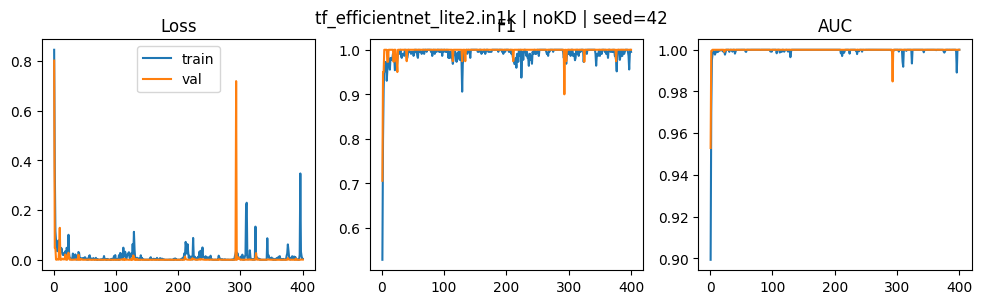

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.2710  F1=0.826  AUC=0.980
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[99  7]
 [ 1 19]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_513047/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=3.0837 f1=0.402 auc=0.766 | val: loss=4.2460 f1=0.415 auc=0.803
[02/400] train: loss=2.5927 f1=0.477 auc=0.860 | val: loss=2.5559 f1=0.351 auc=0.677
[03/400] train: loss=1.6335 f1=0.513 auc=0.876 | val: loss=1.6432 f1=0.618 auc=0.928
[04/400] train: loss=1.1296 f1=0.604 auc=0.923 | val: loss=1.0684 f1=0.655 auc=0.921
[05/400] train: loss=0.8080 f1=0.627 auc=0.953 | val: loss=0.7365 f1=0.680 auc=0.951
[06/400] train: loss=0.6338 f1=0.685 auc=0.957 | val: loss=0.6258 f1=0.636 auc=0.927
[07/400] train: loss=0.5286 f1=0.703 auc=0.970 | val: loss=0.5146 f1=0.698 auc=0.912
[08/400] train: loss=0.4045 f1=0.784 auc=0.987 | val: loss=0.4245 f1=0.872 auc=0.948
[09/400] train: loss=0.4040 f1=0.750 auc=0.983 | val: loss=0.3943 f1=0.698 auc=0.929
[10/400] train: loss=0.3377 f1=0.798 auc=0.985 | val: loss=0.3880 f1=0.837 auc=0.984
[11/400] train: loss=0.3223 f1=0.797 auc=0.989 | val: loss=0.2937 f1=0.844 auc=0.993
[12/400] train: loss=0.3378 f1=0.826 auc=0.995 | val: loss=0.2706

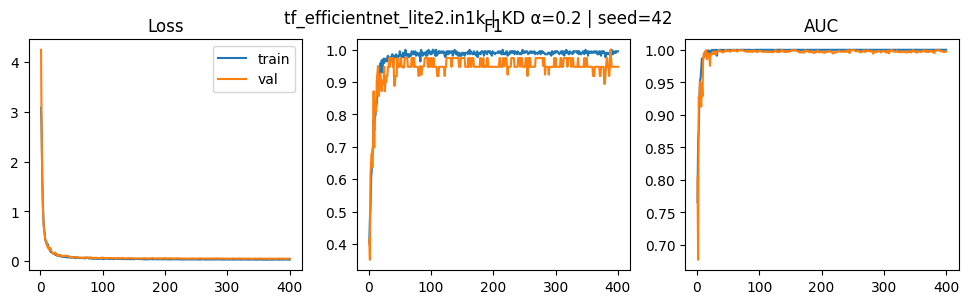

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1405  F1=0.952  AUC=0.997
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[104   2]
 [  0  20]]

--------------------------------------------------------------------------------
[tf_efficientnet_lite2.in1k] RUN 2 / 5 | seed=43
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=1.2795 f1=0.429 auc=0.813 | val: loss=0.1870 f1=0.865 auc=0.985
[02/400] train: loss=0.2839 f1=0.840 auc=0.977 | val: loss=0.0970 f1=0.947 auc=0.996
[03/400] train: loss=0.1190 f1=0.912 auc=0.994 | val: loss=0.0064 f1=1.000 auc=1.000
[04/400] train: loss=0.1368 f1=0.892 auc=0.996 | val: loss=0.0055 f1=1.000 auc=1.000
[05/400] train: loss=0.0541 f1=0.934 auc=0.998 | val: loss=0.0057 f1=1.000 auc=1.000
[06/400] train: loss=0.0255 f1=0.968 auc=1.000 | val: loss=0.0270 f1=0.973 auc=1.000
[07/400] train: loss=0.0699 f1=0.926 auc=0.998 | val: loss=0.0008 f1=1.000 auc=

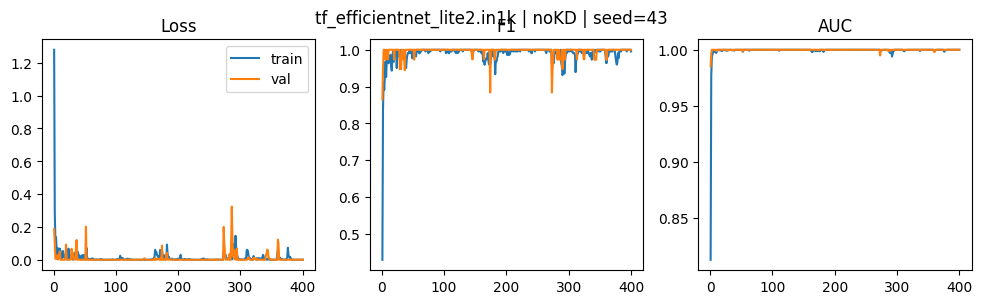

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1894  F1=0.829  AUC=0.987
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[102   4]
 [  3  17]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_513047/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=3.2944 f1=0.356 auc=0.709 | val: loss=3.9683 f1=0.408 auc=0.741
[02/400] train: loss=2.8847 f1=0.432 auc=0.806 | val: loss=2.5205 f1=0.464 auc=0.810
[03/400] train: loss=1.4421 f1=0.514 auc=0.907 | val: loss=1.9921 f1=0.522 auc=0.842
[04/400] train: loss=1.0246 f1=0.597 auc=0.942 | val: loss=1.3612 f1=0.600 auc=0.850
[05/400] train: loss=0.7565 f1=0.686 auc=0.967 | val: loss=0.8685 f1=0.558 auc=0.866
[06/400] train: loss=0.6444 f1=0.660 auc=0.953 | val: loss=0.7351 f1=0.638 auc=0.904
[07/400] train: loss=0.5252 f1=0.743 auc=0.979 | val: loss=0.7130 f1=0.651 auc=0.898
[08/400] train: loss=0.4683 f1=0.717 auc=0.972 | val: loss=0.5228 f1=0.727 auc=0.948
[09/400] train: loss=0.4196 f1=0.763 auc=0.990 | val: loss=0.4640 f1=0.750 auc=0.959
[10/400] train: loss=0.3391 f1=0.805 auc=0.984 | val: loss=0.4305 f1=0.727 auc=0.969
[11/400] train: loss=0.3273 f1=0.802 auc=0.993 | val: loss=0.3530 f1=0.800 auc=0.966
[12/400] train: loss=0.2746 f1=0.847 auc=0.994 | val: loss=0.3175

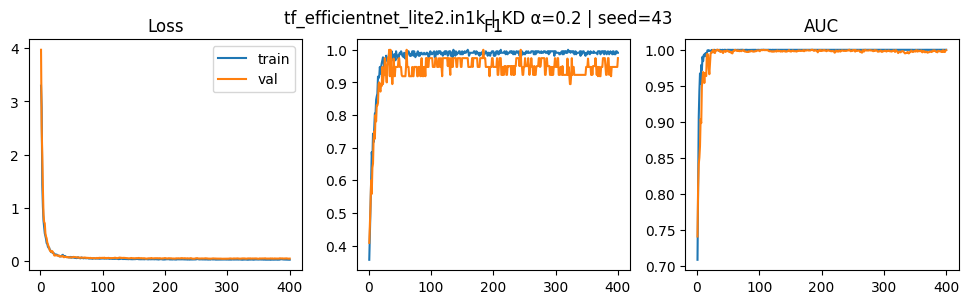

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1615  F1=0.900  AUC=0.987
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[104   2]
 [  2  18]]

--------------------------------------------------------------------------------
[tf_efficientnet_lite2.in1k] RUN 3 / 5 | seed=44
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=1.0158 f1=0.496 auc=0.860 | val: loss=0.4886 f1=0.842 auc=0.967
[02/400] train: loss=0.3178 f1=0.798 auc=0.974 | val: loss=0.1410 f1=0.900 auc=0.995
[03/400] train: loss=0.0931 f1=0.907 auc=0.996 | val: loss=0.0699 f1=0.947 auc=0.999
[04/400] train: loss=0.0906 f1=0.942 auc=0.996 | val: loss=0.1569 f1=0.895 auc=0.998
[05/400] train: loss=0.1194 f1=0.917 auc=0.994 | val: loss=0.1036 f1=0.947 auc=0.999
[06/400] train: loss=0.0629 f1=0.941 auc=0.998 | val: loss=0.0150 f1=0.974 auc=0.999
[07/400] train: loss=0.0921 f1=0.929 auc=0.997 | val: loss=0.0065 f1=1.000 auc=

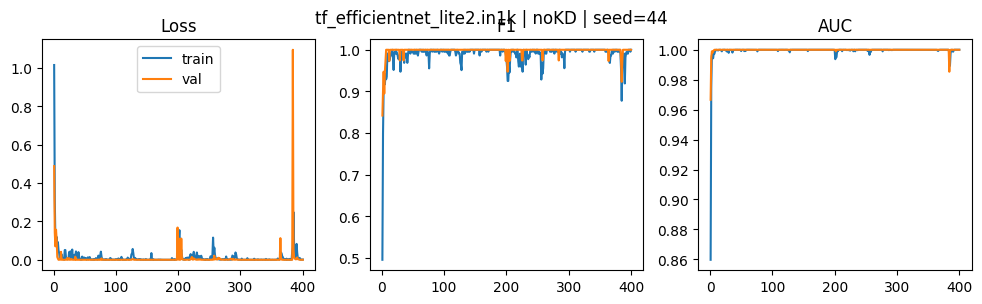

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1526  F1=0.905  AUC=0.993
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[103   3]
 [  1  19]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_513047/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=3.0529 f1=0.387 auc=0.733 | val: loss=3.9080 f1=0.444 auc=0.851
[02/400] train: loss=2.7356 f1=0.478 auc=0.848 | val: loss=1.9539 f1=0.467 auc=0.863
[03/400] train: loss=1.6379 f1=0.494 auc=0.875 | val: loss=1.6572 f1=0.621 auc=0.961
[04/400] train: loss=1.0618 f1=0.604 auc=0.940 | val: loss=1.0710 f1=0.607 auc=0.929
[05/400] train: loss=0.9353 f1=0.591 auc=0.937 | val: loss=0.7642 f1=0.621 auc=0.940
[06/400] train: loss=0.5953 f1=0.689 auc=0.974 | val: loss=0.6618 f1=0.642 auc=0.960
[07/400] train: loss=0.5109 f1=0.757 auc=0.976 | val: loss=0.4688 f1=0.698 auc=0.964
[08/400] train: loss=0.4333 f1=0.782 auc=0.981 | val: loss=0.4784 f1=0.723 auc=0.946
[09/400] train: loss=0.4017 f1=0.744 auc=0.990 | val: loss=0.4033 f1=0.667 auc=0.938
[10/400] train: loss=0.3703 f1=0.779 auc=0.986 | val: loss=0.3185 f1=0.732 auc=0.923
[11/400] train: loss=0.3027 f1=0.819 auc=0.992 | val: loss=0.2676 f1=0.800 auc=0.967
[12/400] train: loss=0.3070 f1=0.831 auc=0.985 | val: loss=0.2536

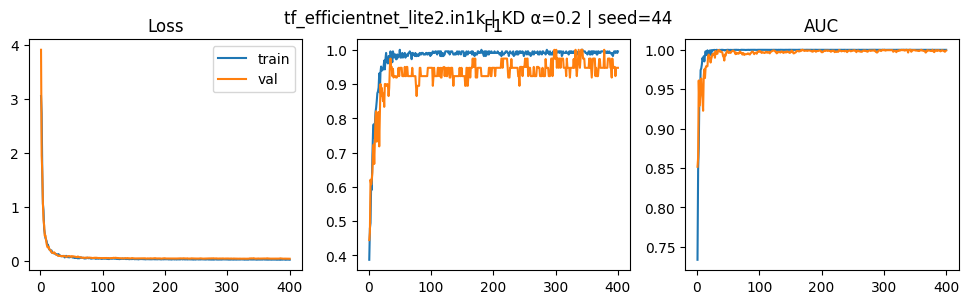

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1343  F1=0.895  AUC=0.998
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[105   1]
 [  3  17]]

--------------------------------------------------------------------------------
[tf_efficientnet_lite2.in1k] RUN 4 / 5 | seed=45
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=1.1968 f1=0.542 auc=0.860 | val: loss=0.6487 f1=0.842 auc=0.984
[02/400] train: loss=0.3687 f1=0.793 auc=0.977 | val: loss=0.3634 f1=0.769 auc=0.978
[03/400] train: loss=0.1713 f1=0.898 auc=0.990 | val: loss=0.0179 f1=0.973 auc=1.000
[04/400] train: loss=0.1376 f1=0.910 auc=0.994 | val: loss=0.0002 f1=1.000 auc=1.000
[05/400] train: loss=0.0314 f1=0.969 auc=0.999 | val: loss=0.0014 f1=1.000 auc=1.000
[06/400] train: loss=0.0545 f1=0.968 auc=0.999 | val: loss=0.0008 f1=1.000 auc=1.000
[07/400] train: loss=0.0566 f1=0.952 auc=0.998 | val: loss=0.0063 f1=1.000 auc=

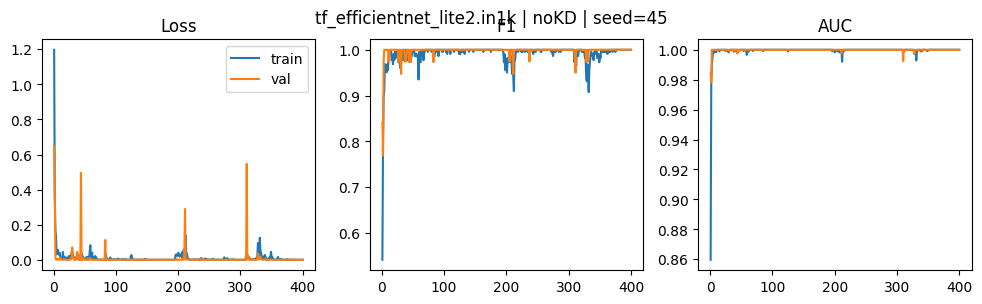

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.4093  F1=0.833  AUC=0.986
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[98  8]
 [ 0 20]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_513047/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=4.0352 f1=0.399 auc=0.726 | val: loss=4.4047 f1=0.409 auc=0.801
[02/400] train: loss=2.7020 f1=0.462 auc=0.845 | val: loss=3.1675 f1=0.558 auc=0.898
[03/400] train: loss=1.4783 f1=0.543 auc=0.904 | val: loss=1.9141 f1=0.558 auc=0.898
[04/400] train: loss=0.8725 f1=0.613 auc=0.954 | val: loss=0.9932 f1=0.632 auc=0.922
[05/400] train: loss=0.6981 f1=0.662 auc=0.930 | val: loss=0.7553 f1=0.593 auc=0.931
[06/400] train: loss=0.5827 f1=0.698 auc=0.965 | val: loss=0.7761 f1=0.711 auc=0.956
[07/400] train: loss=0.4650 f1=0.733 auc=0.981 | val: loss=0.5679 f1=0.708 auc=0.973
[08/400] train: loss=0.4331 f1=0.798 auc=0.977 | val: loss=0.4738 f1=0.837 auc=0.986
[09/400] train: loss=0.3375 f1=0.760 auc=0.988 | val: loss=0.4459 f1=0.837 auc=0.988
[10/400] train: loss=0.3380 f1=0.814 auc=0.992 | val: loss=0.3315 f1=0.857 auc=0.991
[11/400] train: loss=0.2896 f1=0.824 auc=0.991 | val: loss=0.3078 f1=0.947 auc=0.996
[12/400] train: loss=0.2535 f1=0.892 auc=0.993 | val: loss=0.3248

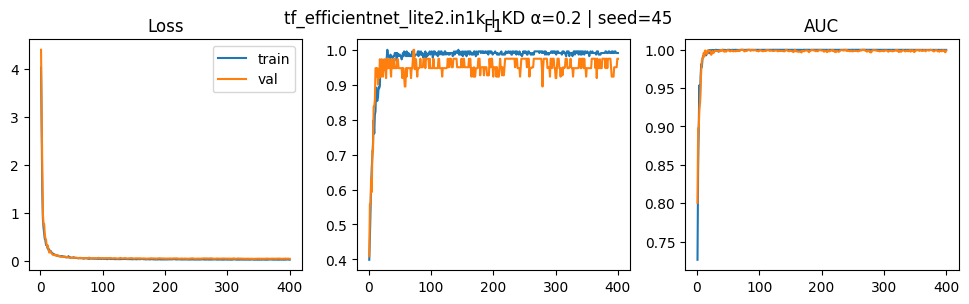

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1701  F1=0.857  AUC=0.989
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[102   4]
 [  2  18]]

--------------------------------------------------------------------------------
[tf_efficientnet_lite2.in1k] RUN 5 / 5 | seed=46
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=1.8762 f1=0.383 auc=0.801 | val: loss=0.3240 f1=0.717 auc=0.994
[02/400] train: loss=0.1916 f1=0.861 auc=0.989 | val: loss=0.0180 f1=0.974 auc=1.000
[03/400] train: loss=0.1693 f1=0.874 auc=0.993 | val: loss=0.0015 f1=1.000 auc=1.000
[04/400] train: loss=0.0587 f1=0.950 auc=0.999 | val: loss=0.0009 f1=1.000 auc=1.000
[05/400] train: loss=0.0804 f1=0.922 auc=0.997 | val: loss=0.0106 f1=0.974 auc=1.000
[06/400] train: loss=0.0497 f1=0.955 auc=0.998 | val: loss=0.0002 f1=1.000 auc=1.000
[07/400] train: loss=0.0057 f1=0.986 auc=1.000 | val: loss=0.0001 f1=1.000 auc=

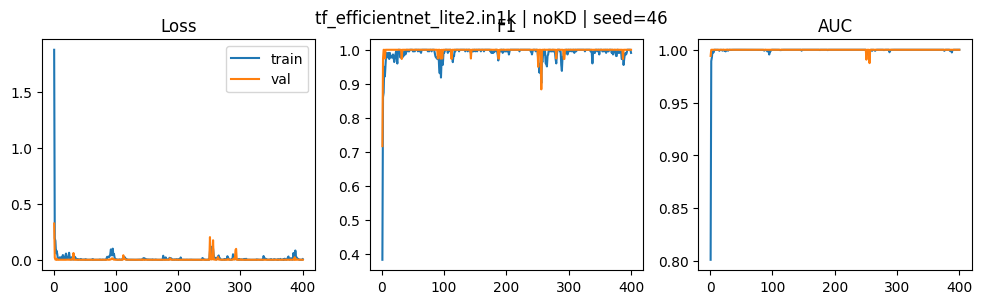

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1889  F1=0.829  AUC=0.980
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[102   4]
 [  3  17]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_513047/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=4.9086 f1=0.328 auc=0.683 | val: loss=7.8850 f1=0.355 auc=0.841
[02/400] train: loss=2.4126 f1=0.458 auc=0.836 | val: loss=2.5224 f1=0.479 auc=0.889
[03/400] train: loss=1.2368 f1=0.552 auc=0.927 | val: loss=1.6005 f1=0.562 auc=0.943
[04/400] train: loss=0.9218 f1=0.601 auc=0.942 | val: loss=1.1100 f1=0.667 auc=0.948
[05/400] train: loss=0.6336 f1=0.685 auc=0.967 | val: loss=0.7568 f1=0.708 auc=0.971
[06/400] train: loss=0.4792 f1=0.741 auc=0.983 | val: loss=0.4879 f1=0.762 auc=0.968
[07/400] train: loss=0.4415 f1=0.769 auc=0.989 | val: loss=0.4646 f1=0.780 auc=0.933
[08/400] train: loss=0.4319 f1=0.718 auc=0.965 | val: loss=0.4209 f1=0.792 auc=0.994
[09/400] train: loss=0.3120 f1=0.848 auc=0.991 | val: loss=0.4117 f1=0.780 auc=0.979
[10/400] train: loss=0.3360 f1=0.830 auc=0.987 | val: loss=0.3189 f1=0.810 auc=0.972
[11/400] train: loss=0.2592 f1=0.844 auc=0.991 | val: loss=0.2743 f1=0.878 auc=0.992
[12/400] train: loss=0.2175 f1=0.892 auc=0.998 | val: loss=0.2330

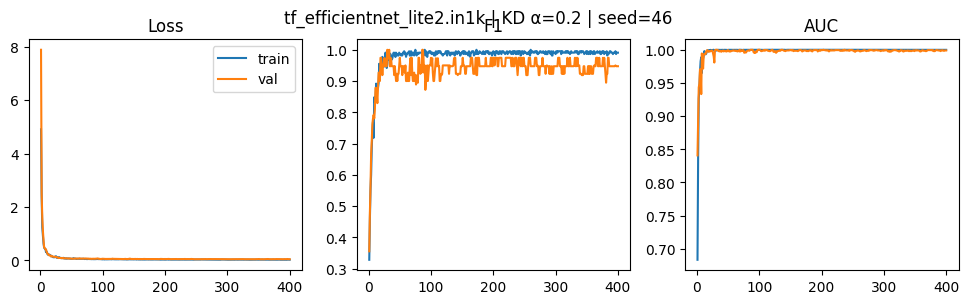

/tmp/ipykernel_513047/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1894  F1=0.900  AUC=0.987
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[104   2]
 [  2  18]]


,model,mode,alpha,seed,repeat_idx,best_val_auc,test_loss,test_f1,test_auc,tn,fp,fn,tp,ckpt_path
0,tf_efficientnet_lite2.in1k,noKD,NaN,42,0,1.0,0.271032,0.826087,0.979717,99,7,1,19,experiments/repeats/tf_efficientnet_lite2_in1k...
1,tf_efficientnet_lite2.in1k,KD,0.2,42,0,1.0,0.140465,0.952381,0.996698,104,2,0,20,experiments/repeats/tf_efficientnet_lite2_in1k...
2,tf_efficientnet_lite2.in1k,noKD,NaN,43,1,1.0,0.189391,0.829268,0.987264,102,4,3,17,experiments/repeats/tf_efficientnet_lite2_in1k...
3,tf_efficientnet_lite2.in1k,KD,0.2,43,1,1.0,0.161459,0.900000,0.987264,104,2,2,18,experiments/repeats/tf_efficientnet_lite2_in1k...
4,tf_efficientnet_lite2.in1k,noKD,NaN,44,2,1.0,0.152559,0.904762,0.993396,103,3,1,19,experiments/repeats/tf_efficientnet_lite2_in1k...
5,tf_efficientnet_lite2.in1k,KD,0.2,44,2,1.0,0.134297,0.894737,0.998113,105,1,3,17,experiments/repeats/tf_efficientnet_lite2_in1k...
6,tf_efficientnet_lite2.in1k,noKD,NaN,45,3,1.0,0.409298,0.833333,0.985849,98,8,0,20,experiments/repeats/tf_efficientnet_lite2_in1k...
7,tf_efficientnet_lite2.in1k,KD,0.2,45,3,1.0,0.170101,0.857143,0.989151,102,4,2,18,experiments/repeats/tf_efficientnet_lite2_in1k...
8,tf_efficientnet_lite2.in1k,noKD,NaN,46,4,1.0,0.188924,0.829268,0.980189,102,4,3,17,experiments/repeats/tf_efficientnet_lite2_in1k...
9,tf_efficientnet_lite2.in1k,KD,0.2,46,4,1.0,0.189372,0.900000,0.986792,104,2,2,18,experiments/repeats/tf_efficientnet_lite2_in1k...


test_f1            test_auc            \
                                           mean       std      mean       std   
model                      mode alpha                                           
tf_efficientnet_lite2.in1k KD   0.2    0.900852  0.033928  0.991604  0.005393   
                           noKD NaN    0.844544  0.033761  0.985283  0.005635   

                                      best_val_auc          tn             fp  \
                                              mean  std   mean       std mean   
model                      mode alpha                                           
tf_efficientnet_lite2.in1k KD   0.2            1.0  0.0  103.8  1.095445  2.2   
                           noKD NaN            1.0  0.0  100.8  2.167948  5.2   

                                                  fn              tp            
                                            std mean       std  mean       std  
model                      mode alpha                                           
tf_efficientnet_lite2.in1k KD   0.2    1.095445  1.8  1.095445  18.2  1.095445  
                           noKD NaN    2.167948  1.6  1.341641  18.4  1.341641

In [41]:
# student_candidates = [
#     ("tf_efficientnet_lite0.in1k",        224, 64),
#     ("tf_efficientnet_lite2.in1k",        260, 48),
#     ("tf_mobilenetv3_small_100.in1k",     224, 96),
#     ("tf_mobilenetv3_large_100.in1k",     224, 64),
#     ("mobilenetv3_large_100.ra_in1k",     224, 64),
# ]

BEST_ALPHA_PER_STUDENT = {
    "tf_mobilenetv3_large_100.in1k": 0.2,
    "tf_efficientnet_lite0.in1k": 0.2,
    "tf_efficientnet_lite2.in1k": 0.2,
    "tf_mobilenetv3_small_100.in1k": 0.2,
    "mobilenetv3_large_100.ra_in1k": 0.2
}

RUN_SEEDS = [42, 43, 44, 45, 46]

def make_loaders_for_student(student_name: str, img_sz: int, bs: int):
    full_rows = splits["train"] + splits["val"]

    train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

    ds_full = RowsDataset(full_rows, train_tf_full)
    dl_full = DataLoader(
        ds_full,
        batch_size=bs,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    ds_val_student = RowsDataset(splits["val"], val_tf_full)
    val_dl_student = DataLoader(
        ds_val_student,
        batch_size=bs,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    test_tf_student = T.Compose([
        T.Resize((img_sz, img_sz)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
    test_dl_student = DataLoader(
        test_ds_student,
        batch_size=bs,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    return dl_full, val_dl_student, test_dl_student

def make_cfg_for_run(base_cfg: TrainConfig,
                     student_name: str,
                     out_dir: str,
                     img_sz: int,
                     bs: int,
                     use_distill: bool,
                     alpha: float,
                     seed: int):
    return TrainConfig(
        train_csv            = base_cfg.train_csv,
        val_csv              = base_cfg.val_csv,
        test_csv             = base_cfg.test_csv,
        img_size             = img_sz,
        robust_aug           = base_cfg.robust_aug,
        batch_size           = bs,
        num_workers          = base_cfg.num_workers,
        use_class_weight     = True,
        use_weighted_sampler = False,
        epochs               = base_cfg.epochs,
        lr                   = base_cfg.lr,
        weight_decay         = base_cfg.weight_decay,
        early_stop_patience  = base_cfg.early_stop_patience,
        seed                 = seed,
        amp                  = base_cfg.amp,
        model_name           = student_name,
        num_classes          = base_cfg.num_classes,
        use_distill          = use_distill,
        teacher_ckpt         = base_cfg.teacher_ckpt,
        distill_alpha        = alpha,
        distill_T            = base_cfg.distill_T,
        out_dir              = out_dir,
        save_best_name       = "best_student.pt",
    )

all_results = []

for (student_name, img_sz, bs) in student_candidates:
    print("\n" + "#"*90)
    print("STUDENT:", student_name, "| img_sz:", img_sz, "| batch_size:", bs)
    print("#"*90)

    dl_full, val_dl_student, test_dl_student = make_loaders_for_student(student_name, img_sz, bs)

    alpha_best = BEST_ALPHA_PER_STUDENT.get(student_name, cfg.distill_alpha)

    for rep_idx, seed in enumerate(RUN_SEEDS):
        print("\n" + "-"*80)
        print(f"[{student_name}] RUN {rep_idx+1} / {len(RUN_SEEDS)} | seed={seed}")
        print("-"*80)

        out_dir_no_kd = os.path.join(
            "experiments",
            "repeats",
            student_name.replace(".", "_"),
            f"noKD",
            f"seed_{seed}"
        )
        cfg_no_kd = make_cfg_for_run(
            cfg,
            student_name=student_name,
            out_dir=out_dir_no_kd,
            img_sz=img_sz,
            bs=bs,
            use_distill=False,
            alpha=alpha_best,
            seed=seed,
        )

        best_ckpt_no_kd, best_val_auc_no_kd = train_model_with_loaders(
            cfg_no_kd, dl_full, val_dl_student,
            verbose=1,
            log_csv=True
        )

        plot_run_curves(cfg_no_kd.out_dir,
                        title=f"{student_name} | noKD | seed={seed}")

        test_loss, test_f1, test_auc, cm = quick_test_eval(
            best_ckpt_no_kd,
            cfg_no_kd.model_name,
            test_dl_student
        )

        all_results.append({
            "model": student_name,
            "mode": "noKD",
            "alpha": None,
            "seed": seed,
            "repeat_idx": rep_idx,
            "best_val_auc": best_val_auc_no_kd,
            "test_loss": test_loss,
            "test_f1": test_f1,
            "test_auc": test_auc,
            "tn": int(cm[0,0]),
            "fp": int(cm[0,1]),
            "fn": int(cm[1,0]),
            "tp": int(cm[1,1]),
            "ckpt_path": best_ckpt_no_kd,
        })

        out_dir_kd = os.path.join(
            "experiments",
            "repeats",
            student_name.replace(".", "_"),
            f"KD_alpha{str(alpha_best).replace('.','_')}",
            f"seed_{seed}"
        )

        cfg_kd = make_cfg_for_run(
            cfg,
            student_name=student_name,
            out_dir=out_dir_kd,
            img_sz=img_sz,
            bs=bs,
            use_distill=True,
            alpha=alpha_best,
            seed=seed,
        )

        best_ckpt_kd, best_val_auc_kd = train_model_with_loaders(
            cfg_kd, dl_full, val_dl_student,
            verbose=1,
            log_csv=True
        )

        plot_run_curves(cfg_kd.out_dir,
                        title=f"{student_name} | KD α={alpha_best} | seed={seed}")

        test_loss, test_f1, test_auc, cm = quick_test_eval(
            best_ckpt_kd,
            cfg_kd.model_name,
            test_dl_student
        )

        all_results.append({
            "model": student_name,
            "mode": "KD",
            "alpha": float(alpha_best),
            "seed": seed,
            "repeat_idx": rep_idx,
            "best_val_auc": best_val_auc_kd,
            "test_loss": test_loss,
            "test_f1": test_f1,
            "test_auc": test_auc,
            "tn": int(cm[0,0]),
            "fp": int(cm[0,1]),
            "fn": int(cm[1,0]),
            "tp": int(cm[1,1]),
            "ckpt_path": best_ckpt_kd,
        })

os.makedirs("experiments/summary", exist_ok=True)
df_results = pd.DataFrame(all_results)
df_results.to_csv("experiments/summary/repeats_results.csv", index=False)
display(df_results)

summary = (
    df_results
    .groupby(["model","mode","alpha"], dropna=False)[["test_f1","test_auc","best_val_auc","tn","fp","fn","tp"]]
    .agg(["mean","std"])
)
display(summary)


In [42]:
summary = (
    df_results
    .groupby(["model","mode","alpha"], dropna=False)[["test_f1","test_auc","test_loss"]]
    .agg(["mean","std"])
)
display(summary)

test_f1            test_auc            \
                                           mean       std      mean       std   
model                      mode alpha                                           
tf_efficientnet_lite2.in1k KD   0.2    0.900852  0.033928  0.991604  0.005393   
                           noKD NaN    0.844544  0.033761  0.985283  0.005635   

                                      test_loss            
                                           mean       std  
model                      mode alpha                      
tf_efficientnet_lite2.in1k KD   0.2    0.159139  0.022391  
                           noKD NaN    0.242241  0.102975

In [43]:
def plot_run_curves(run_dir, title=None):
    csv_path = os.path.join(run_dir, "train_log.csv")
    if not os.path.exists(csv_path):
        print("missing:", csv_path); return
    df = pd.read_csv(csv_path)
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(df.epoch, df.tr_loss, label="train"); ax[0].plot(df.epoch, df.va_loss, label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(df.epoch, df.tr_f1, label="train"); ax[1].plot(df.epoch, df.va_f1, label="val")
    ax[1].set_title("F1")
    ax[2].plot(df.epoch, df.tr_auc, label="train"); ax[2].plot(df.epoch, df.va_auc, label="val")
    ax[2].set_title("AUC")
    if title: fig.suptitle(title)
    plt.show()

In [44]:
plt.figure(figsize=(7,4))
plt.bar(df_summary["model"], df_summary["mean_auc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean AUC (CV)")
plt.title("CV Mean AUC by Candidate")
plt.tight_layout(); plt.show()

NameError: name 'df_summary' is not defined

<Figure size 700x400 with 0 Axes>

In [ ]:
models = sorted(df_perfold["model"].unique())
data = [df_perfold[df_perfold["model"]==m]["val_auc"].values for m in models]

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=models, showmeans=True)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Val AUC"); plt.title("Per-fold AUC distribution")
plt.tight_layout(); plt.show()

In [ ]:
import os
print(cfg_final.out_dir)
log_path = os.path.join(cfg_final.out_dir, "train_log.csv")
if os.path.exists(log_path):
    logdf = pd.read_csv(log_path)
    plt.figure(figsize=(6,4))
    plt.plot(logdf["epoch"], logdf["tr_auc"], label="train AUC")
    plt.plot(logdf["epoch"], logdf["va_auc"], label="val AUC")
    plt.xlabel("epoch"); plt.ylabel("AUC"); plt.title("Training curve (final)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(logdf["epoch"], logdf["tr_f1"], label="train F1")
    plt.plot(logdf["epoch"], logdf["va_f1"], label="val F1")
    plt.xlabel("epoch"); plt.ylabel("F1"); plt.title("Training curve (final)")
    plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc
import numpy as np, torch

model = create_model(cfg_final.model_name, 2).to(device)
model.load_state_dict(torch.load(best_ckpt, map_location=device)); model.eval()

y_prob, y_true = [], []
with torch.no_grad():
    for x, y in test_dl_student:
        x = x.to(device)
        p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
        y_prob.append(p); y_true.append(y.numpy())
y_prob = np.concatenate(y_prob); y_true = np.concatenate(y_true)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = sk_auc(fpr, tpr)
plt.figure(figsize=(5,4)); plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
plt.legend(); plt.tight_layout(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_auc = sk_auc(rec, prec)
plt.figure(figsize=(5,4)); plt.plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (test)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
def collect_probs_labels(ckpt_path, arch_name, dataloader):
    model = create_model(arch_name, 2).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    probs=[]; labels=[]
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(device); 
            p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
            probs.append(p); labels.append(y.numpy())
    return np.concatenate(probs), np.concatenate(labels)

In [ ]:
def plot_roc_pr(y_true, y_prob, title=""):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = sk_auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = np.trapz(prec, rec)

    fig = plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.title(f"ROC AUC = {roc_auc:.3f}"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.subplot(1,2,2)
    plt.plot(rec, prec)
    plt.title(f"PR curve (area ≈ {pr_auc:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
    fig.suptitle(title)
    plt.show()

In [ ]:
def find_best_f1_threshold(y_true, y_prob):
    thr_list = np.linspace(0.05, 0.95, 37)
    best = (0.5, -1.0)
    for thr in thr_list:
        f1 = f1_score(y_true, (y_prob>=thr).astype(int))
        if f1 > best[1]: best = (thr, f1)
    return best

In [ ]:
def show_confusion(y_true, y_prob, thr=0.5, title=""):
    y_hat = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    fig = plt.figure(figsize=(3,3))
    plt.imshow(cm, cmap="Blues"); plt.title(title)
    plt.xticks([0,1],["Pred Safe","Pred Viol"]); plt.yticks([0,1],["True Safe","True Viol"])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]), ha='center', va='center')
    plt.show()
    return cm

In [ ]:
teacher_arch = "tf_efficientnetv2_l"
teacher_ckpt = "models/server/best_server.pt"
yprob_te, ytrue_te = collect_probs_labels(teacher_ckpt, teacher_arch, test_dl)
plot_roc_pr(ytrue_te, yprob_te, title="TEACHER")
thr_te, bestf1_te = find_best_f1_threshold(ytrue_te, yprob_te)
print("Teacher best-F1 thr:", round(thr_te,2), "F1=", round(bestf1_te,3))
_ = show_confusion(ytrue_te, yprob_te, thr=0.5, title="Teacher CM @0.5")
_ = show_confusion(ytrue_te, yprob_te, thr=thr_te, title=f"Teacher CM @thr={thr_te:.2f}")

In [ ]:
best_student_arch = cfg_final.model_name
best_student_ckpt = best_ckpt
print("Best student:", best_student_arch)
print("Checkpoint path:", best_student_ckpt)

In [ ]:
yprob_st, ytrue_st = collect_probs_labels(best_student_ckpt, best_student_arch, test_dl_student) 
plot_roc_pr(ytrue_st, yprob_st, title=f"STUDENT: {best_student_arch}")
thr_st, bestf1_st = find_best_f1_threshold(ytrue_st, yprob_st)
print("Student best-F1 thr:", round(thr_st,2), "F1=", round(bestf1_st,3))
_ = show_confusion(ytrue_st, yprob_st, thr=0.5, title="Student CM @0.5")
_ = show_confusion(ytrue_st, yprob_st, thr=thr_st, title=f"Student CM @thr={thr_st:.2f}")

plot_roc_pr(ytrue_st, yprob_st, title=f"STUDENT: {best_student_arch}")
thr_st, bestf1_st = find_best_f1_threshold(ytrue_st, yprob_st)
print("Student best-F1 thr:", round(thr_st,2), "F1=", round(bestf1_st,3))
_ = show_confusion(ytrue_st, yprob_st, thr=0.5, title="Student CM @0.5")
_ = show_confusion(ytrue_st, yprob_st, thr=thr_st, title=f"Student CM @thr={thr_st:.2f}")

In [ ]:
df = score_kd.copy()
fig=plt.figure(figsize=(6,4))
plt.scatter(df["test_auc"], df["latency_ms_1x"])
for _,r in df.iterrows():
    plt.annotate(r["model"], (r["test_auc"], r["latency_ms_1x"]), fontsize=8, xytext=(2,2), textcoords="offset points")
plt.xlabel("Test AUC (higher better)")
plt.ylabel("Latency per image (ms, lower better)")
plt.title("Accuracy vs Latency (students)")
plt.grid(True, ls="--", alpha=.4)
plt.show()

In [ ]:
# ARCH_STUDENT = "tf_efficientnet_lite2" 
# NUM_CLASSES  = 2
# IMG_SIZE     = 224

# CKPT_STUDENT = "models/client/best_student.pt"
# EXPORT_DIR   = "export_tflite"
# LABELS_TXT   = f"{EXPORT_DIR}/labels.txt"

# DATA_TRAIN_DIR = "data/train"


In [ ]:
# !pip install -q onnx onnxsim onnx-tf

# import os, io, random, numpy as np
# import torch, timm
# from PIL import Image

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model_student = timm.create_model(
#     ARCH_STUDENT, pretrained=False, num_classes=NUM_CLASSES
# ).to(device)

# sd = torch.load(CKPT_STUDENT, map_location=device)
# state_dict = sd.get("state_dict", sd.get("model", sd))
# if state_dict is None:
#     state_dict = sd
# model_student.load_state_dict(state_dict, strict=True)
# model_student.eval()

# print("Loaded:", ARCH_STUDENT, "classes:", NUM_CLASSES)

In [ ]:
# os.makedirs(EXPORT_DIR, exist_ok=True)
# ONNX_RAW = f"{EXPORT_DIR}/student_raw.onnx"
# ONNX_SIM = f"{EXPORT_DIR}/student_sim.onnx"

# dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)

# torch.onnx.export(
#     model_student, dummy, ONNX_RAW,
#     input_names=["input"], output_names=["logits"],
#     opset_version=13, do_constant_folding=True, dynamic_axes=None
# )

# print("ONNX saved:", ONNX_RAW)

In [ ]:
# import onnx
# from onnxsim import simplify

# model_onnx = onnx.load(ONNX_RAW)
# model_simplified, check = simplify(model_onnx)
# assert check, "Simplified ONNX model could not be validated"
# onnx.save(model_simplified, ONNX_SIM)
# print("ONNX simplified saved:", ONNX_SIM)

In [ ]:
# from onnx_tf.backend import prepare

# model_onnx = onnx.load(ONNX_SIM)
# tf_rep = prepare(model_onnx)  # konversi ke representasi TF
# TF_SAVED_DIR = f"{EXPORT_DIR}/tf_saved"
# if os.path.exists(TF_SAVED_DIR):
#     import shutil; shutil.rmtree(TF_SAVED_DIR)

# tf_rep.export_graph(TF_SAVED_DIR)
# print("TF SavedModel:", TF_SAVED_DIR)

In [ ]:
# import tensorflow as tf
# import pathlib, itertools

# TFL_FP32 = f"{EXPORT_DIR}/student_fp32.tflite"
# TFL_FP16 = f"{EXPORT_DIR}/student_fp16.tflite"
# TFL_INT8 = f"{EXPORT_DIR}/student_int8.tflite"

# # FP32 (baseline)
# conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
# tfl32 = conv.convert()
# open(TFL_FP32, "wb").write(tfl32)

# # FP16 (disarankan: kecil, cepat, akurasi hampir sama)
# conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
# conv.optimizations = [tf.lite.Optimize.DEFAULT]
# conv.target_spec.supported_types = [tf.float16]
# tfl16 = conv.convert()
# open(TFL_FP16, "wb").write(tfl16)

# # INT8 (paling kecil; butuh representative dataset)
# # Kita sampling beberapa gambar dari train_dir, lakukan preprocessing ImageNet (sesuai training)
# def representative_dataset_gen(folder=DATA_TRAIN_DIR, samples=100):
#     import os, random
#     from PIL import Image
#     paths = []
#     for cls in os.listdir(folder):
#         cpath = os.path.join(folder, cls)
#         if os.path.isdir(cpath):
#             for p in os.listdir(cpath):
#                 if p.lower().endswith((".jpg",".jpeg",".png")):
#                     paths.append(os.path.join(cpath, p))
#     random.shuffle(paths)
#     paths = paths[:samples]

#     mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)[None,None,:]
#     std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)[None,None,:]

#     for p in paths:
#         img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
#         x = np.array(img, dtype=np.float32) / 255.0
#         x = (x - mean) / std
#         x = np.expand_dims(x, axis=0)  # [1,H,W,3] karena TF SavedModel biasanya NHWC
#         # Beberapa converter expect NCHW; jika perlu, transpose ke NCHW:
#         # x = np.transpose(x, (0,3,1,2))
#         yield [x]

# try:
#     conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
#     conv.optimizations = [tf.lite.Optimize.DEFAULT]
#     conv.representative_dataset = lambda: representative_dataset_gen(DATA_TRAIN_DIR, 100)
#     # Mode int8 “full integer” jika memungkinkan:
#     conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#     # Tipe input/output (bisa uint8 atau int8 tergantung preferensi):
#     conv.inference_input_type = tf.float32  # sering lebih aman; biarkan float32 supaya preprocessing tetap float
#     conv.inference_output_type = tf.float32
#     tfl8 = conv.convert()
#     open(TFL_INT8, "wb").write(tfl8)
#     print("INT8 TFLite created.")
# except Exception as e:
#     print("INT8 conversion skipped due to:", e)

# print("TFLite ready:", TFL_FP32, TFL_FP16, "(and possibly)", TFL_INT8)

In [ ]:
# # Ambil satu gambar uji
# TEST_IMG = "data/val/violence/xxx.jpg"   # ganti satu file nyata

# # Preprocess (PyTorch)
# def preprocess_pt(pil):
#     x = np.array(pil.resize((IMG_SIZE, IMG_SIZE)), dtype=np.float32)/255.0
#     x = (x - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
#     x = np.transpose(x, (2,0,1))  # CHW
#     x = torch.from_numpy(x).unsqueeze(0).to(device)
#     return x

# # Preprocess (TF/TFLite) NHWC
# def preprocess_tf(pil):
#     x = np.array(pil.resize((IMG_SIZE, IMG_SIZE)), dtype=np.float32)/255.0
#     x = (x - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
#     x = np.expand_dims(x, 0)  # NHWC
#     return x

# from scipy.special import softmax
# pil = Image.open(TEST_IMG).convert("RGB")

# # PyTorch logits -> prob
# with torch.no_grad():
#     pt_in = preprocess_pt(pil)
#     pt_logits = model_student(pt_in).cpu().numpy()
#     pt_prob = softmax(pt_logits, axis=1)[0]
# print("PyTorch prob:", pt_prob)

# # TFLite (FP16) inference
# import tensorflow as tf
# interpreter = tf.lite.Interpreter(model_path=TFL_FP16)
# interpreter.allocate_tensors()
# inp = interpreter.get_input_details()[0]
# out = interpreter.get_output_details()[0]

# tf_in = preprocess_tf(pil).astype(np.float32)

# # Jika input shape butuh NCHW (jarang), transpose di sini.
# interpreter.set_tensor(inp['index'], tf_in)
# interpreter.invoke()
# tfl_logits = interpreter.get_tensor(out['index'])
# tfl_prob = softmax(tfl_logits, axis=1)[0]
# print("TFLite prob:", tfl_prob)

In [ ]:
# with open(LABELS_TXT, "w") as f:
#     f.write("safe\nviolence\n")
# print("Labels saved:", LABELS_TXT)

In [ ]:
# from PIL import Image
# import torch, numpy as np
# import torchvision.transforms as T

# @torch.inference_mode()
# def predict_image(ckpt_path: str,
#                   arch_name: str,
#                   img_path: str,
#                   img_size: int = 224,
#                   threshold: float = 0.5):

#     model = create_model(arch_name, num_classes=2, pretrained=False).to(device)
#     sd = torch.load(ckpt_path, map_location=device)
#     model.load_state_dict(sd)
#     model.eval()

#     # preprocessing (samakan dengan val_tf kamu)
#     tf = T.Compose([
#         T.Resize((img_size, img_size)),
#         T.ToTensor(),
#         T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
#     ])

#     # open image
#     img = Image.open(img_path).convert("RGB")
#     x = tf(img).unsqueeze(0).to(device)  # [1,3,H,W]

#     # forward
#     logits = model(x)
#     prob = torch.softmax(logits, dim=1)[0,1].item()  # prob kelas 1 = "Violence"
#     pred = int(prob >= threshold)

#     return {
#         "path": img_path,
#         "arch": arch_name,
#         "checkpoint": ckpt_path,
#         "img_size": img_size,
#         "prob_violence": float(prob),
#         "pred_label": pred,  # 1 = Violence, 0 = Safe
#         "threshold": threshold,
#     }

# res_teacher = predict_image(
#     ckpt_path="models/server/best_server.pt",
#     arch_name="tf_efficientnetv2_l", 
#     img_path="tes3.jpg",
#     img_size=320, 
#     threshold=0.5
# )
# print(res_teacher)

# res_student = predict_image(
#     ckpt_path="experiments/runs/student_tf_efficientnet_lite0_in1k_kd/best_student.pt",
#     arch_name="tf_efficientnet_lite0.in1k",
#     img_path="tes3.jpg",
#     img_size=224, 
#     threshold=0.5
# )
# print(res_student)
